In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchvision
import captum
import captum.optim as optimviz

In [3]:
# get alexnet
from alexnet import model as alexnet

print(alexnet)

Using cache found in /home/kevin/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
# Run BigGAN

import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       convert_to_images)

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.ERROR)

# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256').to("cuda")

In [27]:
def show_gan_image(vec: torch.Tensor):
    truncation = 0.4
    # Generate an image
    with torch.no_grad():
        output = model.generator(vec, truncation=truncation)

    # If you have a GPU put back on CPU
    output = output.to('cpu')

    imgs = convert_to_images(output)
    display(imgs[0])

In [6]:
import captum
import captum.optim as optimviz

In [7]:
# Normal image optimization with captum appears to work
target = alexnet.features[8]
channel = 0

image = optimviz.images.NaturalImage((224, 224)).to("cuda")
loss_fn = optimviz.loss.ChannelActivation(target, channel)
transforms = torch.nn.Sequential(
    torch.nn.ReflectionPad2d(4),
    optimviz.transforms.RandomSpatialJitter(8),
    optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5, 5)),
    optimviz.transforms.RandomSpatialJitter(2),
)
obj = optimviz.InputOptimization(
    alexnet, input_param=image, loss_function=loss_fn)
history = obj.optimize(optimviz.optimization.n_steps(128, True))

  0%|          | 0/128 [00:00<?, ? step/s]

/home/kevin/.local/share/virtualenvs/231nFinalProject-K6JlCK0i/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:934.)
  return super(Tensor, self).refine_names(names)


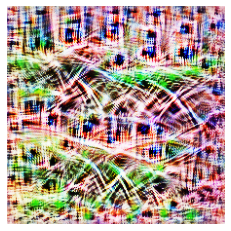

In [8]:
image().show()

In [10]:
# Cooler image optimization
class GANifier(torch.nn.Module):
    def __init__(self, gan, model):
        super(GANifier, self).__init__()
        self.gan = gan
        self.resize = torchvision.transforms.Resize((224, 224))
        self.model = model

    def forward(self, noise_vector):
        truncation = 0.4    
        output = self.gan.generator(noise_vector, truncation=truncation)
        output = self.resize(output)
        output = self.model(output)

        return output

In [35]:
ganifier = GANifier(model, alexnet)

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom'], batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=3)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

print(noise_vector.shape, class_vector.shape)

torch.Size([3, 128]) torch.Size([3, 1000])


In [39]:
target = ganifier.model.features[8]
channel = 100

class BadInputParametizer(torch.nn.Module):
    def __init__(self):
        super(BadInputParametizer, self).__init__()
        v = torch.tensor(truncated_noise_sample(truncation=0.4, batch_size=1), requires_grad=True).to("cuda")
        class_vec = model.embeddings(torch.tensor(one_hot_from_names(["coffee"], batch_size=1), requires_grad=True).to("cuda"))
        self.v = torch.nn.Parameter(torch.cat((v, class_vec), dim=1))

        print(self.v.shape)
    
    def forward(self):
        return self.v

# image = noise_vector
# transforms = torch.nn.Sequential(
#     torch.nn.ReflectionPad2d(4),
#     optimviz.transforms.RandomSpatialJitter(8),
#     optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
#     torchvision.transforms.RandomRotation(degrees=(-5, 5)),
#     optimviz.transforms.RandomSpatialJitter(2),
# )
# obj = optimviz.InputOptimization(
#     ganifier, input_param=image, loss_function=loss_fn)
# history = obj.optimize(optimviz.optimization.n_steps(128, True))

input = BadInputParametizer()
loss_fn = optimviz.loss.ChannelActivation(target, channel)
io = optimviz.InputOptimization(ganifier, loss_fn, input, torch.nn.Identity())
io.optimize(optimviz.optimization.n_steps(128, True))

torch.Size([1, 256])


  0%|          | 0/128 [00:00<?, ? step/s]

tensor([-1.5393, -0.9248, -1.6375, -1.4898, -1.3009, -0.9782, -1.1040, -1.1055,
        -1.3926, -1.6331, -1.7630, -1.6816, -1.3761, -1.0715, -0.7889, -0.8940,
        -0.9492, -1.1414, -1.1412, -1.0760, -1.0594, -1.0752, -1.2348, -1.3696,
        -1.5009, -1.5747, -1.7474, -1.7455, -1.7659, -1.7147, -1.6422, -1.5940,
        -1.6675, -1.7554, -1.8139, -1.8790, -1.9503, -2.0010, -1.9782, -1.9558,
        -1.9709, -1.9988, -1.9927, -2.0327, -2.0787, -2.0918, -2.0528, -2.0485,
        -2.0817, -2.0876, -2.1456, -2.1585, -2.1702, -2.1926, -2.2035, -2.2047,
        -2.2254, -2.2501, -2.2662, -2.3009, -2.3256, -2.3330, -2.3692, -2.3663,
        -2.3884, -2.3957, -2.4003, -2.4096, -2.4473, -2.4455, -2.4754, -2.4687,
        -2.4816, -2.4972, -2.5264, -2.5467, -2.5348, -2.6164, -2.4820, -2.6093,
        -2.5968, -2.6021, -2.6704, -2.6999, -2.7111, -2.7051, -2.7453, -2.7712,
        -2.7768, -2.7880, -2.8012, -2.8731, -2.9259, -2.9169, -2.9560, -2.9910,
        -3.0434, -3.0176, -3.0495, -2.97

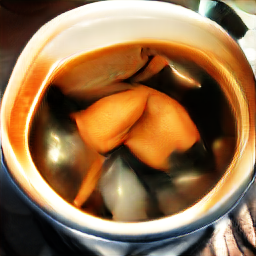

In [40]:
show_gan_image(input.v)